## Objective : Predict whether a given day will recieve rainfall or not
### Table of content:
### 1. Data pre-processing
##### 1.1 Encoding
##### 1.2 Scaling
### 2. Test Train split
### 3. Feature selection/removal
##### 3.1 Multi-colinearity checks
##### 3.2 Variability checks
### 4. Feature importance
##### 4.1 Sigmoid classifier - logistic regression
##### 4.2 Tree based - Random forest classifier
##### - Why not sampling?
### 5. Logistic Regression
##### 5.1 Finding the optimal probability threshold for classifying
###### 5.1.1 Sensetivity VS Specificity intersection point
###### 5.1.2 Model re-run with optimal threshold
##### 5.2 Analysis of Logistic regression model output
###### 5.2.1 Actual VS predicted 1/0 counts graph
###### 5.2.2 Model summery using classification accuracy metrics
### 6. Random Forest classifier
###### 6.1 Model hyper paramter selection
##### 6.2 Analysis of Random forest classifier model output
###### 6.2.1 Sensetivity VS specificity intersection point
###### 6.2.2 Actual VS predicted 1/0 counts graph
###### 6.2.3 Model summery using classification accuracy metrics 

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from mlxtend.preprocessing import minmax_scaling

import plotly.graph_objects as go
#import plotly.subplots as sp
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from IPython.display import HTML, display, Markdown, clear_output

from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from statistics import mean
from sklearn import metrics
import matplotlib.pyplot as plt
 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import minimize_scalar

%matplotlib inline

### Data pre-processing 
#### 1. One hot encoding of categorical features
#### 2. Min max scaling

In [3]:
weather_aus_df = pd.read_csv('weather_df_final.csv')
weather_aus_df = weather_aus_df.drop(weather_aus_df.columns[0], axis=1)
weather_aus_df = weather_aus_df.drop('Date', axis=1)
#weather_aus_df

In [4]:
weather_aus_df['RainToday'] = weather_aus_df['RainToday'].replace({'No': 0, 'Yes': 1})
weather_aus_df['RainTomorrow'] = weather_aus_df['RainTomorrow'].replace({'No': 0, 'Yes': 1})
#weather_aus_df

weather_aus_df_y = weather_aus_df[['RainTomorrow']]

weather_aus_df_cat = weather_aus_df.select_dtypes(include=['category', 'object'])
weather_aus_df_cat = weather_aus_df_cat.drop('Season', axis=1)

weather_aus_df_cat_encoded = pd.get_dummies(weather_aus_df_cat).astype(int)
#weather_aus_df_cat_encoded

weather_aus_df_num = weather_aus_df.select_dtypes(include='number')
weather_aus_df_num = weather_aus_df_num.drop('RainTomorrow', axis=1)


weather_aus_df_num_minmaxsc = minmax_scaling(weather_aus_df_num
                                             , columns=weather_aus_df_num.columns)

#weather_aus_df_num_minmaxsc

weather_aus_df_preproc = pd.merge(weather_aus_df_cat_encoded, weather_aus_df_num_minmaxsc
                                  , left_index=True, right_index=True)

weather_aus_df_preproc = pd.merge(weather_aus_df_preproc, weather_aus_df_y
                                 , left_index=True, right_index=True)

#weather_aus_df_preproc 

weather_aus_df_preproc = weather_aus_df_preproc.drop('RISK_MM', axis=1)

### Test train split

In [6]:
## Target variable selection and split % 
target_var='RainTomorrow'
split_percentage=25

In [7]:
## X and y seperation
split_perc=split_percentage/100
X=weather_aus_df_preproc.loc[:,weather_aus_df_preproc.columns]
y=weather_aus_df_preproc[target_var]
X=X.drop(target_var,axis=1)

In [8]:
## Splitting the data for modelling (without oversampling)
x_train,x_valid,y_train,y_valid=train_test_split(X,y,test_size=split_perc,random_state=0)

print("Training-Validation Split Percentage:{split}".format(split=int((1-split_perc)*100)))
print("Total Observation:{obs}".format(obs=X.shape[0]))
print("Training Observation:{train_obs}".format(train_obs=x_train.shape[0]))
print("Validation Observation:{valid_obs}".format(valid_obs=x_valid.shape[0]))

Training-Validation Split Percentage:75
Total Observation:142193
Training Observation:106644
Validation Observation:35549


### Feature selection
#### 1. Multi colinearity checks
#### 2. Variability checks

In [9]:

# def multi_collinear(x_train_processed):
#     truncate_value=15
#     exog_df=x_train_processed.loc[:,x_train_processed.columns!=target_var]
#     exog_df=x_train_processed.copy()
    
#     exog_df=add_constant(exog_df)
#     vifs=pd.Series([1/(1.-OLS(exog_df[col].values,
#                               exog_df.loc[:,exog_df.columns!=col].values).fit().rsquared) for col in exog_df],
#                    index=exog_df.columns,
#                    name='VIF')
    
#     vifs=pd.DataFrame(vifs)
#     vifs.drop('const',axis=0,inplace=True)
#     vifs=vifs['VIF'].where(vifs['VIF']<=truncate_value,truncate_value)
#     vifs=pd.DataFrame(vifs)
#     vifs_df=vifs.sort_values(by=['VIF'],ascending=True)
    
#     vifs_df['colors']=np.where(vifs_df.VIF<=5,'yellowgreen',
#                                  np.where((vifs_df.VIF>5) & (vifs_df.VIF<=10),'steelblue','tomato'))
    
#     Layout=go.Layout(title="VIF plot", xaxis=dict(title='VIF'),yaxis=dict(title='Features'))
#     fig=go.Figure(go.Bar(x=vifs_df.VIF,y=vifs_df.index.tolist(),
#                          orientation='h',marker_color=vifs_df['colors']),layout=Layout)
#     fig.add_shape(type="line",x0=5,y0=0,x1=5,y1=len(vifs_df.index.tolist()),
#                   line=dict(color="midnightblue",width=2,dash="dot"))
#     fig.add_shape(type="line",x0=10,y0=0,x1=10,y1=len(vifs_df.index.tolist()),
#                   line=dict(color="midnightblue",width=2,dash="dot"))
    
#     fig.update_layout(width=800,height=800)
#     fig.show(config={'displaylogo':False})
#     return vifs

# vifs=multi_collinear(x_train)


# def multi_col_vars(vifs):
#     multicorr_vars=vifs['VIF'].loc[lambda x:x>=10].index.tolist()
#     col_to_drop=multicorr_vars
    
#     if col_to_drop==[]:
#         #clear_output()
#         print("No columns were dropped")
#     else:
#         #clear_output()
#         x_train.drop(col_to_drop,axis=1,inplace=True)
#         display(Markdown('Successfully dropped:{}'.format(",".join(col_to_drop))))
        
#         display(x_train.dtypes)
#     return x_train


# x_train=multi_col_vars(vifs)

In [10]:
# Chceking variability between the column values
def variability(x_train):
    selected_features=[]
    selected_features_dict={}
    col_drop=[]
    zero_variance=(x_train.describe().loc['std']==0)
    zero_variance=zero_variance[zero_variance].index.tolist()
    if len(zero_variance)==0:
        print('No columns with 0 std dev.')
    else:
        display(pd.DataFrame(zero_varinace,columns=['Features']))
        col_drop.extend(zero_variance)
    return selected_features,selected_features_dict,col_drop

variability(x_train)

No columns with 0 std dev.


([], {}, [])

In [11]:
## Filtering the list of columns in the x_test dataframe as per the x_train VIF removed columns
x_test=[]
for i in x_train:
    if i in x_valid:
        x_test.append(i)
        
x_test=x_valid[x_test]
#x_test

### Feature importance 
#### 1. Sigmoid classifier i.e Logistic regression 
#### 2. Tree based - Random Forest

In [12]:
## Checking the "m" value of the features using Logistic regression model 
LR = LogisticRegression()

LR.fit(x_train / np.std(x_train, 0), y_train)
importanceLR=LR.coef_

importanceLR=importanceLR.tolist()
importanceLR=[item for sublist in importanceLR for item in sublist]
importanceLR=[abs(ele) for ele in importanceLR]

feat_labels=x_train.columns[:]
feat_labels=feat_labels.tolist()

df_imp_LR=pd.DataFrame({'Features':feat_labels,'Importance_LR':importanceLR}).sort_values('Importance_LR', ascending=False)
#df_imp_LR

df_top10_fea_cols = df_imp_LR.head(10)
LR_top10_fea = df_top10_fea_cols['Features'].tolist()

df_top25 = df_imp_LR.head(25)

fig = px.bar(df_top25, x='Features', y='Importance_LR',
             labels={'Importance_LR': 'Importance (LR)', 'Features': 'Features'},
             title='Top 10 Features Importance (LR) coeffs from Logistic Regression',
             color='Importance_LR', 
             color_continuous_scale='Viridis')

fig.show()

In [13]:
## Checking the importance of the features using random forest baseline model 
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
    
importances=forest.feature_importances_
importances=importances.tolist()

feat_labels= x_train.columns[:]
feat_labels=feat_labels.tolist()

df_imp_rf=pd.DataFrame({'Features':feat_labels,'Importance_RF':importances}).sort_values('Importance_RF', ascending=False)
#df_imp_rf

df_top10_fea_cols = df_imp_rf.head(10)
RF_top10_fea = df_top10_fea_cols['Features'].tolist()

df_top25 = df_imp_rf.head(25)

fig = px.bar(df_top25, x='Features', y='Importance_RF',
             labels={'Importance_LR': 'Importance (RF)', 'Features': 'Features'},
             title='Top 10 Features Importance (RF) % from Random Forest',
             color='Importance_RF',  # Optional: Color bars based on importance
             color_continuous_scale='Viridis')

fig.show()

### Why not sampling?
#### The data has Y variable class imbalance, doing oversampling or understanding would unnecessarily add model bias, information loss and difficulty in generalisation of output, in the data. Here we have good amount of 'Yes', not a huge imbalance i.e. 110K 'No' & 32k 'Yes' and models will be able to handle it with proper hyperparameter tuning.  

### Logistic regression model

Accuracy (test dataset) of the logistic regression model: 0.8500098455652761
Accuracy (train dataset) of the logistic regression model: 0.8478864258654965
              precision    recall  f1-score   support

     class 0       0.87      0.94      0.91     27543
     class 1       0.73      0.53      0.61      8006

    accuracy                           0.85     35549
   macro avg       0.80      0.73      0.76     35549
weighted avg       0.84      0.85      0.84     35549

[[26008  1535]
 [ 3797  4209]]


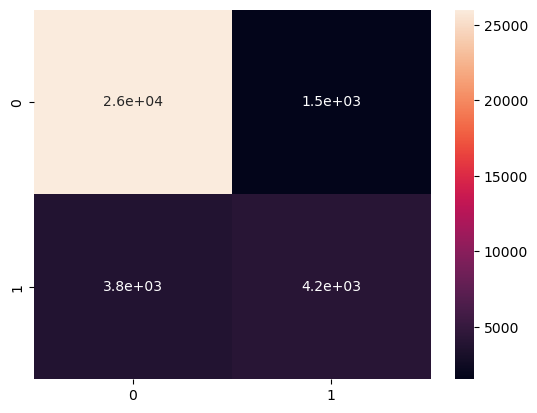

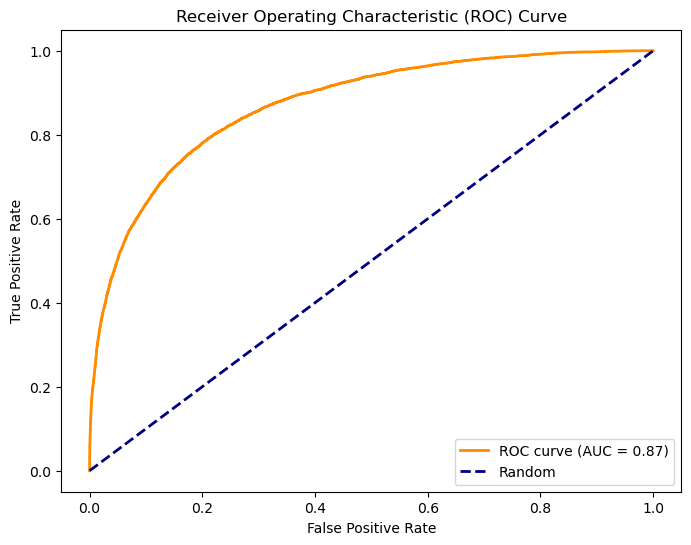

In [14]:
# LR train model
logistic_clf = LogisticRegression(solver='liblinear', random_state=5000).fit(x_train, y_train)
y_pred=logistic_clf.predict(x_test)
print("Accuracy (test dataset) of the logistic regression model:",metrics.accuracy_score(y_valid, y_pred))

y_pred_train=logistic_clf.predict(x_train)
print("Accuracy (train dataset) of the logistic regression model:",metrics.accuracy_score(y_train, y_pred_train))

target_names = ['class 0', 'class 1']
print(classification_report(y_valid, y_pred, target_names=target_names))

#confusion matrix
cf_matrix = confusion_matrix(y_valid, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

y_score = logistic_clf.predict_proba(x_test)[:, 1]

# Calculating the ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_score)

# Calculating the AUC score
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Finding the optimal probability threshold for classifying
#### Sensetivity VS Specificity intersection point
#### Model re-run with optimal threshold 

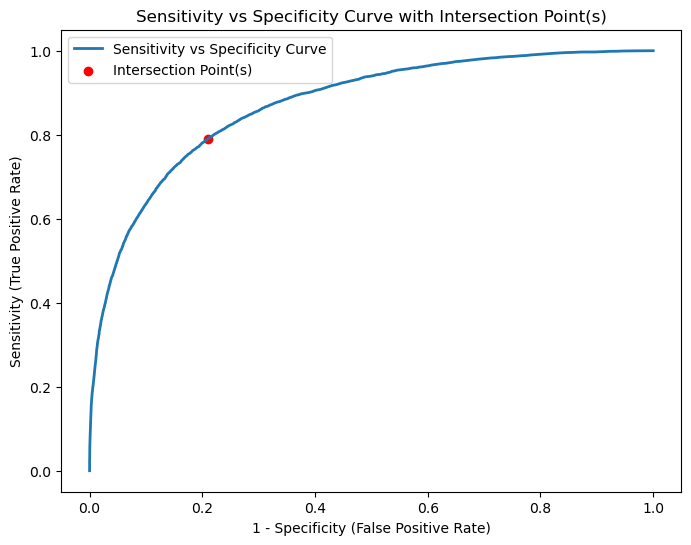

Intersection Point(s): [(0.2093453872127219, 0.7900324756432675)]


In [15]:
thresholds = np.linspace(0, 1, 1000)
sensitivity = []
specificity = []

for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

# Finding the intersection point(s)
intersection_points = []

for i in range(1, len(thresholds)):
    if (sensitivity[i] >= specificity[i-1]) and (sensitivity[i] <= specificity[i]):
        intersection_points.append((1 - specificity[i], sensitivity[i]))

plt.figure(figsize=(8, 6))
plt.plot(1 - np.array(specificity), np.array(sensitivity), lw=2, label='Sensitivity vs Specificity Curve')

# Checking if there are intersection points before unpacking
if intersection_points:
    x, y = zip(*intersection_points)  # Unpack the tuples
    plt.scatter(x, y, color='red', label='Intersection Point(s)')

plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Sensitivity vs Specificity Curve with Intersection Point(s)')
plt.legend()
plt.show()

print("Intersection Point(s):", intersection_points)


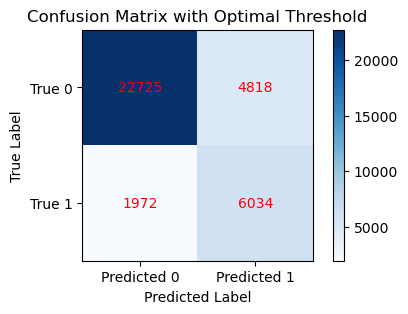

Accuracy with Optimal Threshold: 0.8089960336437031
Sensitivity with Optimal Threshold: 0.7536847364476642
Specificity with Optimal Threshold: 0.8250735214028972


In [16]:
# Use the optimal threshold for prediction on the validation set

optimal_threshold = 0.25
y_pred_optimal = (y_score >= optimal_threshold).astype(int)

# Evaluating the performance with the optimal threshold
conf_matrix_optimal = confusion_matrix(y_valid, y_pred_optimal)

# Calculating accuracies
accuracy_optimal = accuracy_score(y_valid, y_pred_optimal)
sensitivity_optimal = conf_matrix_optimal[1, 1] / (conf_matrix_optimal[1, 0] + conf_matrix_optimal[1, 1])
specificity_optimal = conf_matrix_optimal[0, 0] / (conf_matrix_optimal[0, 0] + conf_matrix_optimal[0, 1])

plt.figure(figsize=(5, 3))
plt.imshow(conf_matrix_optimal, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Optimal Threshold')
plt.colorbar()

for i in range(conf_matrix_optimal.shape[0]):
    for j in range(conf_matrix_optimal.shape[1]):
        plt.text(j, i, str(conf_matrix_optimal[i, j]), ha='center', va='center', color='red')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], ['True 0', 'True 1'])
plt.show()

# Displaying new accuracies
print("Accuracy with Optimal Threshold:", accuracy_optimal)
print("Sensitivity with Optimal Threshold:", sensitivity_optimal)
print("Specificity with Optimal Threshold:", specificity_optimal)

### Analysis of Logistic regression model output
#### Actual VS predicted 1/0 counts graph
#### Model summery using classification accuracy metrics

In [17]:
y_valid_rf =pd.DataFrame(y_valid)
#y_valid

y_valid_rf = y_valid_rf['RainTomorrow'].value_counts().sort_index()
#y_valid

#predictions
predictions_rf_df = pd.DataFrame(y_pred_optimal, columns=['RainTomorrow_pred'])
#predictionsdf
predictions_rf_df = predictions_rf_df['RainTomorrow_pred'].value_counts().sort_index()
#predictionsdf

combined_df = pd.DataFrame({'Rain Tomorrow': y_valid_rf.index, 'Actuals': y_valid_rf.values, 'Predicted': predictions_rf_df.values})

df_melted = pd.melt(combined_df, id_vars='Rain Tomorrow', value_vars=['Actuals', 'Predicted'], var_name='Data Frame'
                    , value_name='Count')


fig = px.bar(df_melted, x='Rain Tomorrow', y='Count', color='Data Frame',
             labels={'Count': 'Value'},
             title='Actual scenario vs model predicted - Logistic regression',
             barmode='group',
             text='Count')

fig.update_traces(textposition='outside', texttemplate='%{text:.0f}')

fig.update_layout(width=650, height=480)
fig.show()

1. **Precision:** 

   - Precision measures the accuracy of positive predictions. In a binary classification context: 

     - Precision for class 0: 87% means that out of all instances predicted as class 0, 87% were actually class 0. 

     - Precision for class 1: 73% means that out of all instances predicted as class 1, 73% were actually class 1. 

   - Higher precision indicates fewer false positives. 

  
  

2. **Recall (Sensitivity or True Positive Rate):** 

   - Recall measures the ability of the model to capture all relevant instances. In a binary classification context: 

     - Recall for class 0: 94% means that out of all actual instances of class 0, the model correctly identified 94%. 

     - Recall for class 1: 53% means that out of all actual instances of class 1, the model correctly identified 53%. 

   - Higher recall indicates fewer false negatives. 

  

  

3. **F1-Score:** 

   - The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. 

       - F1-score for class 0: 91% 

       - F1-score for class 1: 61% 

   - A higher F1-score indicates a better balance between precision and recall. 

  
  

4. **Support:** 

   - The number of actual occurrences of each class in the dataset. In this case, there are 27,543 instances of class 0 and 8,006 instances of class 1. 

  
  

**In summary:** 

- For class 0, the model has high precision and recall, suggesting that it is performing well in identifying instances of class 0. 

- For class 1, the model has lower precision and recall, indicating that it is less accurate in identifying instances of class 1 but 61% of the times it was able to accurately balance out 'Yes it will rain tomorrow' scenarios

### Random Forest classifier 
#### Selecting the best model hyperparameters

In [18]:
## Random forest best hyperparameter set
param_grid_rf = { 
    'n_estimators': [5, 10, 20, 30, 50],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc=RandomForestClassifier()
gridsearch_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, n_jobs=4)
gridsearch_rfc.fit(x_train, y_train)

final_model_rfc=gridsearch_rfc.best_params_
print("RF best params:",final_model_rfc)

RF best params: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 30}


Accuracy (test dataset) of model RF is 0.8397141973051281
Accuracy (train dataset) of model RF is 0.8442575297250666
              precision    recall  f1-score   support

     class 0       0.85      0.97      0.90     27543
     class 1       0.79      0.40      0.53      8006

    accuracy                           0.84     35549
   macro avg       0.82      0.68      0.72     35549
weighted avg       0.83      0.84      0.82     35549

[[26677   866]
 [ 4832  3174]]


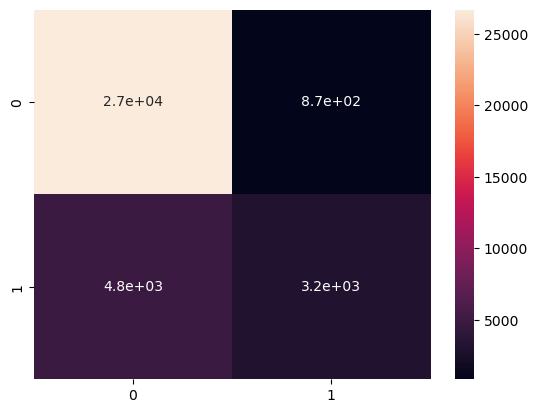

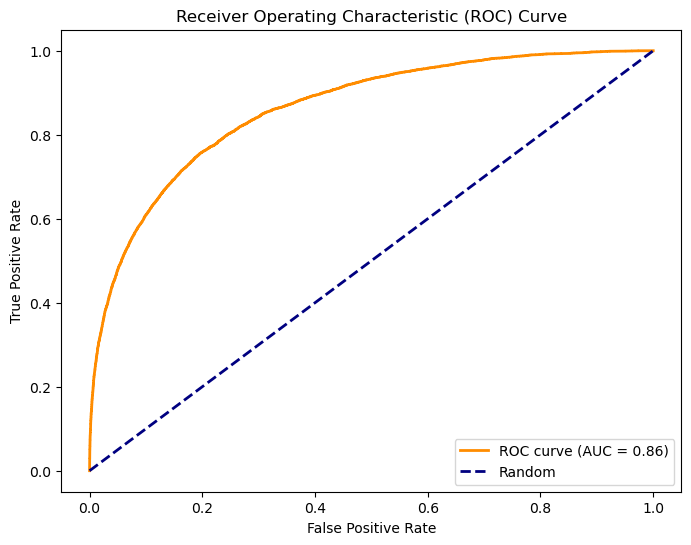

In [19]:
rf_model = RandomForestClassifier(**final_model_rfc, oob_score=True, random_state=200)
rf_model.fit(x_train, y_train)
predictions = rf_model.predict(x_test)

print("Accuracy (test dataset) of model RF is",metrics.accuracy_score(y_valid, predictions))

predictions_train = rf_model.predict(x_train)
print("Accuracy (train dataset) of model RF is",metrics.accuracy_score(y_train, predictions_train))

target_names = ['class 0', 'class 1']
print(classification_report(y_valid, predictions, target_names=target_names))

cf_matrix = confusion_matrix(y_valid, predictions)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

y_score = rf_model.predict_proba(x_test)[:, 1]

# Calculating the ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_score)

# Calculating the AUC score
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Analysis of Random forest classifier model output
#### Sensetivity VS specificity intersection point
#### Actual VS predicted 1/0 counts graph
#### Model summery using classification accuracy metrics

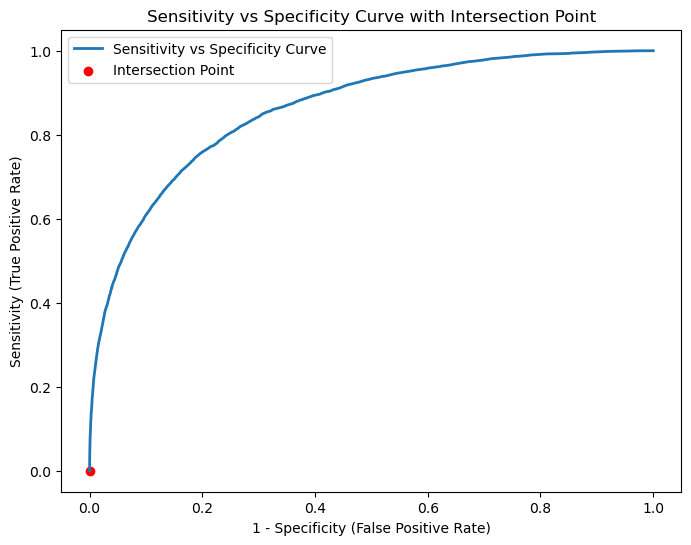

Intersection Point: (5.9608609865491405e-06, 5.9608609865491405e-06)


In [20]:
thresholds = np.linspace(0, 1, 1000)
sensitivity = []
specificity = []

for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

# Defining a function to minimize (the difference between sensitivity and specificity)
objective_function = lambda x: np.abs(np.interp(x, 1 - np.array(specificity), np.array(sensitivity)) - x)

# Finding the optimal threshold (intersection point)
result = minimize_scalar(objective_function, bounds=(0, 1), method='bounded')

plt.figure(figsize=(8, 6))
plt.plot(1 - np.array(specificity), np.array(sensitivity), lw=2, label='Sensitivity vs Specificity Curve')

plt.scatter(result.x, result.fun, color='red', label='Intersection Point')

plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Sensitivity vs Specificity Curve with Intersection Point')
plt.legend()
plt.show()

print("Intersection Point:", (result.x, result.fun))


In [21]:
y_valid=pd.DataFrame(y_valid)
#y_valid

y_valid = y_valid['RainTomorrow'].value_counts().sort_index()
#y_valid

#predictions
predictionsdf = pd.DataFrame(predictions, columns=['RainTomorrow_pred'])
#predictionsdf
predictionsdf = predictionsdf['RainTomorrow_pred'].value_counts().sort_index()
#predictionsdf

combined_df = pd.DataFrame({'Rain Tomorrow': y_valid.index, 'Actuals': y_valid.values, 'Predicted': predictionsdf.values})

df_melted = pd.melt(combined_df, id_vars='Rain Tomorrow', value_vars=['Actuals', 'Predicted'], var_name='Data Frame'
                    , value_name='Count')


fig = px.bar(df_melted, x='Rain Tomorrow', y='Count', color='Data Frame',
             labels={'Count': 'Value'},
             title='Actual scenario vs model predicted - Random Forest',
             barmode='group',
             text='Count')

fig.update_traces(textposition='outside', texttemplate='%{text:.0f}')

fig.update_layout(width=650, height=480)
fig.show()

1. **Precision:** 

   - Precision for class 0: 85% means that out of all instances predicted as class 0, 85% were actually class 0. 

   - Precision for class 1: 79% means that out of all instances predicted as class 1, 79% were actually class 1. 

   - Both values indicate the accuracy of positive predictions. 

  

2. **Recall (Sensitivity or True Positive Rate):** 

   - Recall for class 0: 97% means that out of all actual instances of class 0, the model correctly identified 97%. 

   - Recall for class 1: 40% means that out of all actual instances of class 1, the model correctly identified 40%. 

   - Recall measures the ability of the model to capture all relevant instances. 

 

 

3. **F1-Score:** 

   - F1-score for class 0: 90% 

   - F1-score for class 1: 53% 

   - The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics. 
  

 
   **In summary:**

- The model performs well in predicting class 0 (high precision and recall). 

- For class 1, precision is decent, but recall is lower, indicating that the model is less effective at identifying instances of class 1. 

- The overall accuracy is 84%, but it's essential to consider the class-specific metrics for a comprehensive understanding. 

### Important features for prediction

In [26]:
LR_top10_fea = set(LR_top10_fea)
RF_top10_fea = set(RF_top10_fea)

top_features_list = list(LR_top10_fea.union(RF_top10_fea))

top_features_list

['WindDir3pm_SW',
 'Cloud3pm',
 'Temp3pm',
 'MinTemp',
 'Humidity3pm',
 'WindDir9am_SSE',
 'Sunshine',
 'Pressure3pm',
 'Humidity9am',
 'WindGustDir_E',
 'Location_Katherine',
 'Pressure9am',
 'Cloud9am',
 'WindDir9am_SE',
 'WindGustSpeed']